### import

In [4]:
import os
import json
import logging
from pathlib import Path
from typing import List, Dict, Optional, Tuple
import pandas as pd
import numpy as np

# Display and Image handling
from IPython.display import display
from PIL import Image as PILImage  # 使用 PILImage 作为 PIL.Image 的别名
from IPython.display import Image as IPyImage  # 使用 IPyImage 作为 IPython 的 Image

# Vector DB
import chromadb
from chromadb.utils import embedding_functions

# Embedding Models
from sentence_transformers import SentenceTransformer
from transformers import CLIPProcessor, CLIPModel
import torch

# LLM
import ollama

# PDF处理
import PyPDF2

# 设置日志
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# 检查并创建必要的目录
Path('chroma_db').mkdir(exist_ok=True)
Path('image').mkdir(exist_ok=True)

In [5]:
import sys
import torch
import transformers
import accelerate
print(f"Python version: {sys.version}")
print(f"PyTorch version: {torch.__version__}")
print(f"Transformers version: {transformers.__version__}")
print(f"Accelerate version: {accelerate.__version__}")

Python version: 3.9.19 | packaged by conda-forge | (main, Mar 20 2024, 12:55:20) 
[Clang 16.0.6 ]
PyTorch version: 2.5.1
Transformers version: 4.47.0
Accelerate version: 0.26.0


### voice to text


In [6]:
# whisper /Users/zirong/Desktop/test.mp4 --language Chinese --model tiny
import whisper
def transcribe_file(file_path, model_size="base"):
    model = whisper.load_model(model_size)
    result = model.transcribe(file_path)
    return result["text"]

# def main():
#     audio_file = "no_upload/test_mp3/01.mp3"  # 修改為你的音檔路徑
#     transcription = transcribe_file(audio_file)
#     print("Transcription:", transcription)

# if __name__ == "__main__":
#     main()

### 圖片處理

In [7]:
from typing import Union  # 添加 Union 导入

class ImageProcessor:
    def __init__(self, image_dir: str = "image"):
        self.image_dir = Path(image_dir)
        self.image_dir.mkdir(exist_ok=True)
        
    def process_and_save(
        self,
        image_path: Union[str, Path],  # 使用 Union 替代 |
        target_size: Tuple[int, int],
        prefix: str = "resized_",
        quality: int = 95
    ) -> Optional[Path]:
        """统一的图片处理方法，处理并保存图片"""
        try:
            # 确保 image_path 是 Path 对象
            image_path = Path(image_path)
            if not str(image_path).startswith(str(self.image_dir)):
                image_path = self.image_dir / image_path
                
            # 检查图片是否存在
            if not image_path.exists():
                logger.error(f"Image not found: {image_path}")
                return None
                
            # 读取并处理图片
            image = PILImage.open(image_path)
            
            # 转换为 RGB 模式
            if image.mode != 'RGB':
                image = image.convert('RGB')
                
            # 计算等比例缩放的大小
            width, height = image.size
            ratio = min(target_size[0]/width, target_size[1]/height)
            new_size = (int(width * ratio), int(height * ratio))
            
            # 缩放图片
            image = image.resize(new_size, PILImage.Resampling.LANCZOS)
            
            # 创建新的白色背景图片
            new_image = PILImage.new('RGB', target_size, (255, 255, 255))
            
            # 计算居中位置
            x = (target_size[0] - new_size[0]) // 2
            y = (target_size[1] - new_size[1]) // 2
            
            # 贴上缩放后的图片
            new_image.paste(image, (x, y))
            
            # 生成输出路径
            output_path = self.image_dir / f"{image_path.name}" #output_path = self.image_dir / f"{prefix}{image_path.name}"
            # 保存处理后的图片
            new_image.save(output_path, quality=quality)
            logger.info(f"Saved processed image to: {output_path}")
            
            return output_path
            
        except Exception as e:
            logger.error(f"Error processing image {image_path}: {str(e)}")
            return None
            
    def load_for_display(self, 
                        image_path: Union[str, Path],  # 使用 Union 替代 |
                        display_size: Tuple[int, int]) -> Optional[PILImage.Image]:
        """载入图片用于显示"""
        try:
            processed_path = self.process_and_save(image_path, display_size, prefix="display_")
            if processed_path:
                return PILImage.open(processed_path)
            return None
        except Exception as e:
            logger.error(f"Error loading image for display {image_path}: {str(e)}")
            return None

### Embedding 處理模組

In [8]:
%matplotlib inline
# from IPython.display import display, Image
class HybridEmbeddingProcessor:
    # 初始化 embedding processor
    def __init__(self, 
                persist_directory: str = "chroma_db",
                image_dir: str = "image",
                image_size: tuple = (224, 224)):
        self.image_dir = Path(image_dir)
        self.image_size = image_size
        self.image_processor = ImageProcessor(image_dir)
        
        # 初始化模型
        self.text_model = SentenceTransformer('all-mpnet-base-v2')
        self.clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
        self.clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
        
        # 获取CLIP模型的输出维度
        with torch.no_grad():
            dummy_image = torch.zeros((1, 3, 224, 224))
            image_features = self.clip_model.get_image_features(dummy_image)
            self.image_dimension = image_features.shape[1]  # 应该是 512

        # 设置 Chroma
        logger.info(f"Initializing Chroma with directory: {persist_directory}")
        self.chroma_client = chromadb.PersistentClient(path=persist_directory)
        
        # 使用 SentenceTransformer embedding function
        sentence_transformer_ef = embedding_functions.SentenceTransformerEmbeddingFunction(
            model_name='all-mpnet-base-v2',
            device="cpu"
        )
        
        try:
            # 删除现有的集合
            collections_to_delete = ["questions", "answers", "image_documents"]
            for collection_name in collections_to_delete:
                try:
                    self.chroma_client.delete_collection(collection_name)
                    logger.info(f"Deleted collection: {collection_name}")
                except Exception as e:
                    # pass
                    logger.info(f"Collection {collection_name} does not exist or could not be deleted: {str(e)}")
            
            # 创建新的集合
            # 创建新的集合，指定维度
            sentence_transformer_ef = embedding_functions.SentenceTransformerEmbeddingFunction(
                model_name='all-mpnet-base-v2'
            )

            self.question_collection = self.chroma_client.create_collection(
                name="questions",
                embedding_function=sentence_transformer_ef
            )
            
            self.answer_collection = self.chroma_client.create_collection(
                name="answers",
                embedding_function=sentence_transformer_ef
            )
            
            self.image_collection = self.chroma_client.create_collection(
                name="image_documents",
                metadata={"dimension": self.image_dimension}
            )
            logger.info(f"Created collections with image dimension: {self.image_dimension}")

            
        except Exception as e:
            logger.error(f"Error initializing collections: {str(e)}")
            raise
        
    def process_text_with_clip(self, text: str) -> Optional[np.ndarray]:
        """
        用 CLIP 的 text encoder 做文字 embedding
        """
        try:
            inputs = self.clip_processor(text=[text], return_tensors="pt",truncation=True)
            text_features = self.clip_model.get_text_features(**inputs)
            return text_features.detach().numpy()[0]
        except Exception as e:
            logger.error(f"Error processing text with CLIP: {str(e)}")
            return None

    def add_qa_pairs(self,
                questions: List[str],
                answers: List[str],
                question_metadatas: List[Dict],
                answer_metadatas: List[Dict],
                images: Optional[List[str]] = None):
        """添加问答对到不同的集合"""
        try:
            # 添加问题
            if questions and question_metadatas:
                logger.info(f"Adding {len(questions)} questions")
                self.question_collection.add(
                    documents=questions,
                    metadatas=question_metadatas,
                    ids=[f"q_{i}" for i in range(len(questions))]
                )
            
            # 添加回答
            if answers and answer_metadatas:
                logger.info(f"Adding {len(answers)} answers")
                self.answer_collection.add(
                    documents=answers,
                    metadatas=answer_metadatas,
                    ids=[f"a_{i}" for i in range(len(answers))]
                )
            
            # 处理图片
            if images:
                logger.info(f"Processing {len(images)} images")
                all_ids=[]
                all_embeddings=[]
                all_metadatas = []

                
                for i, (img_path,question_text) in enumerate(zip(images, questions)):
                    img_emb = self.process_image(str(self.image_dir / img_path))
                    txt_emb = self.process_text_with_clip(question_text)

                    if img_emb is not None:
                        all_embeddings.append(img_emb.tolist())
                        # img_embeddings_list = img_embeddings.tolist()
                        # all_metadatas.append(img_embeddings_list)
                        # valid_images.append(img_path)
                        all_metadatas.append({
                            "type": "image", 
                            "path": img_path,
                            "associated_question": question_text
                        })
                        all_ids.append(f"img_{i}")
                    if txt_emb is not None:
                        all_embeddings.append(txt_emb.tolist())  
                        all_metadatas.append({
                            "type": "clip_text", 
                            "text": question_text,
                            "related_image": img_path
                        })
                        all_ids.append(f"txt_{i}")

                if len(all_embeddings)>0:
                    logger.info(f"Adding {len(all_embeddings)} total embeddings to collection")
                    self.image_collection.add(
                        embeddings=all_embeddings,
                        metadatas=all_metadatas,
                        ids=all_ids
                    )
            
        except Exception as e:
            logger.error(f"Error adding QA pairs: {str(e)}")
            raise

    def process_image(self, image_path: str) -> Optional[np.ndarray]:
            """處理圖片並生成 embedding"""
            try:
                logger.info(f"Processing image: {image_path}")
                processed_path = self.image_processor.process_and_save(
                    image_path=image_path,
                    target_size=self.image_size
                )
                
                if processed_path is None:
                    logger.error(f"Failed to process image: {image_path}")
                    return None
                    
                image = PILImage.open(processed_path)
                inputs = self.clip_processor(images=image, return_tensors="pt")
                image_features = self.clip_model.get_image_features(**inputs)
                
                logger.info(f"Successfully generated embedding for image: {image_path}")
                return image_features.detach().numpy()[0]
                
            except Exception as e:
                logger.error(f"Error processing image {image_path}: {str(e)}")
                return None

    def add_documents(self, 
                     texts: List[str], 
                     metadatas: List[Dict],
                     images: Optional[List[str]] = None):
        """添加文件到不同的集合"""
        try:
            # 添加文本文件
            if texts and metadatas:
                logger.info(f"Adding {len(texts)} text documents")
                self.text_collection.add(
                    documents=texts,
                    metadatas=metadatas,
                    ids=[f"text_{i}" for i in range(len(texts))]
                )
                logger.info("Successfully added text documents")
            
            # 處理並添加圖片
            if images:
                logger.info(f"Processing {len(images)} images")
                image_embeddings = []
                valid_images = []
                valid_metadatas = []
                
                for i, img_path in enumerate(images):
                    logger.info(f"Processing image {i+1}/{len(images)}: {img_path}")
                    embedding = self.process_image(str(self.image_dir / img_path))
                    if embedding is not None:
                        image_embeddings.append(embedding.tolist())
                        valid_images.append(img_path)
                        valid_metadatas.append({
                            "type": "image", 
                            "path": img_path,
                            "associated_text": texts[i] if i < len(texts) else ""
                        })
                
                if valid_images:
                    logger.info(f"Adding {len(valid_images)} valid images to collection")
                    self.image_collection.add(
                        embeddings=image_embeddings,
                        metadatas=valid_metadatas,
                        ids=[f"img_{i}" for i in range(len(valid_images))]
                    )
                    logger.info("Successfully added images to collection")
                else:
                    logger.warning("No valid images to add to collection")
        
        except Exception as e:
            logger.error(f"Error adding documents: {str(e)}", exc_info=True)
            raise
    
    def process_text(self, text: str) -> np.ndarray:
        """使用 SentenceTransformer 處理文本"""
        try:
            embedding = self.text_model.encode(text)
            return embedding
        except Exception as e:
            logger.error(f"Error processing text: {str(e)}")
            return None
        
    def search(self, query: str, k: int = 3) -> Dict:
        """整合社群和专业知识的搜索方法"""
        try:
            logger.info("Starting search operation...")
            
            # 1. 搜索社群问答
            social_results = self.question_collection.query(
                query_texts=[query],
                n_results=k
            )
            
            # 2. 搜索专业文献
            professional_results = self.answer_collection.query(
                query_texts=[query],
                n_results=k
            )
            
            # 3. 整合结果并标记来源
            combined_results = {
                "social": {
                    "questions": social_results["documents"][0] if social_results["documents"] else [],
                    "answers": social_results["answers"] if "answers" in social_results else [],
                    "metadata": social_results["metadatas"][0] if social_results["metadatas"] else [],
                    "relevance": social_results["distances"][0] if social_results["distances"] else []
                },
                "professional": {
                    "content": professional_results["documents"][0] if professional_results["documents"] else [],
                    "metadata": professional_results["metadatas"][0] if professional_results["metadatas"] else [],
                    "relevance": professional_results["distances"][0] if professional_results["distances"] else []
                }
            }
            
            

            # 4. 搜索相关图片
            image_results = self._search_images(query, k)
            combined_results["images"] = image_results
            logger.info(f"[DEBUG] image_results(search) = {image_results}")


            return combined_results
                
        except Exception as e:
            logger.error(f"Search error: {str(e)}")
            return {
                "social": {"questions": [], "answers": [], "metadata": [], "relevance": []},
                "professional": {"content": [], "metadata": [], "relevance": []},
                "images": {"metadata": [], "paths": [], "relevance": []}
            }
    def _search_images(self, query: str, k: int = 3) -> Dict:
        """Search for relevant images"""
        try:
            # 圖片用CLIP做embedding,query也要才找得到(對齊)
            emb = self.process_text_with_clip(query)
            
            image_results = self.image_collection.query(
                query_embeddings=[emb],
                n_results=k
            )

            logger.info(f"[DEBUG] image_results(_search) = {image_results}")

            return {
                "metadata": image_results.get("metadatas", []),
                "paths": image_results.get("ids", []),
                "relevance": image_results.get("distances", [])
            }
        except Exception as e:
            logger.error(f"Error searching images: {str(e)}")
            return {
                "metadata": [],
                "paths": [],
                "relevance": []
            }

### 資料處理模組

In [9]:
class DataProcessor:
    def __init__(self, embedding_processor: 'HybridEmbeddingProcessor'):
        self.embedding_processor = embedding_processor
        
    def process_csv_with_images(self, csv_path: str) -> Tuple[List[Dict], List[str]]:
        """处理 CSV 并提取问答对和图片"""
        logger.info(f"Processing CSV: {csv_path}")
        qa_pairs = []
        images = []
        
        df = pd.read_excel(csv_path)#read_csv(csv_path)
        current_post = None
        current_responses = []
        current_images = []
        current_link = None
        
        for _, row in df.iterrows():
            # 处理新的帖子
            if pd.notna(row['post']):
                # 保存前一个问答对
                if current_post is not None:
                    qa_pair = {
                        'question': current_post,
                        'answers': current_responses.copy(),
                        'images': current_images.copy(),
                        'link': current_link,
                        'metadata': {
                            'type': 'social_qa',
                            'source': 'facebook',
                            'images': ','.join(current_images) if current_images else '',
                            'answer_count': len(current_responses)
                        }
                    }
                    qa_pairs.append(qa_pair)
                    if current_images:
                        images.extend(current_images)
                
                # 初始化新的问答对
                current_post = row['post']
                current_responses = []
                current_images = []
                current_link = row.get('link', '')
            
            # 添加回复
            if pd.notna(row.get('responses')):
                current_responses.append(row['responses'])
            
            # 处理图片
            if pd.notna(row.get('images')):
                img_path = row['images']
                current_images.append(img_path)
                logger.info(f"Found image: {img_path} for current post")
        
        # 保存最后一个问答对
        if current_post is not None and len(current_responses) >= 3:
            qa_pair = {
                'question': current_post,
                'answers': current_responses,
                'images': current_images,
                'link': current_link,
                'metadata': {
                    'type': 'social_qa',
                    'source': 'facebook',
                    'images': ','.join(current_images) if current_images else '',
                    'answer_count': len(current_responses)
                }
            }
            qa_pairs.append(qa_pair)
            if current_images:
                images.extend(current_images)
        
        # 显示处理结果的详细信息
        for i, qa in enumerate(qa_pairs):
            logger.info(f"\nQA Pair {i+1}:")
            logger.info(f"Question: {qa['question'][:100]}...")
            logger.info(f"Number of answers: {len(qa['answers'])}")
            logger.info(f"Images: {qa['images']}")
            logger.info(f"Link: {qa.get('link', 'No link')}")
        
        return qa_pairs, images

    def is_title_line(line: str) -> bool:
        """检查是否是标题行"""
        # 清理空白
        line = line.strip()
        if not line:
            return False
            
        # 标题的特征
        is_likely_title = (
            # 全大写或首字母大写
            line.isupper() or line.istitle() or
            # 常见的章节名称
            any(keyword in line.lower() for keyword in [
                'abstract', 'introduction', 'method', 'result', 
                'discussion', 'conclusion', 'reference'
            ]) and
            # 长度适中
            5 < len(line) < 100
        )
        
        return is_likely_title
    
    def clean_title(title: str) -> str:
        """清理并标准化标题文本"""
        # 移除数字和特殊字符
        title = ''.join(c for c in title if c.isalpha() or c.isspace())
        # 清理空白
        title = ' '.join(title.split())
        return title
    
    def process_pdf(self, pdf_path: str) -> List[Dict]:
        logger.info(f"Processing PDF: {pdf_path}")
        professional_qa_pairs = []
        pdf_name = Path(pdf_path).name  # 获取文件名
        
        try:
            with open(pdf_path, 'rb') as file:
                pdf_reader = PyPDF2.PdfReader(file)
                
                for page_num, page in enumerate(pdf_reader.pages):
                    text = page.extract_text()
                    paragraphs = [p.strip() for p in text.split('\n\n') if p.strip()]
                    
                    # 处理每个段落
                    for para in paragraphs:
                        qa_pair = {
                            'question': para[:50] + "...",  # 暂时用段落开头作为问题标识
                            'answers': [para],
                            'metadata': {
                                'type': 'professional',
                                'source_file': pdf_name,  # 添加文件名
                                'page': str(page_num + 1),
                                'content_length': str(len(para))
                            }
                        }
                        professional_qa_pairs.append(qa_pair)
                
                logger.info(f"Extracted {len(professional_qa_pairs)} paragraphs from {pdf_name}")
                return professional_qa_pairs
                
        except Exception as e:
            logger.error(f"Error processing PDF {pdf_name}: {str(e)}")
            return []

    def process_all(self, csv_path: str, pdf_paths: List[str]):
        """处理所有数据：社群数据和多个 PDF"""
        try:
            # 1. 处理社群数据
            social_qa_pairs, images = self.process_csv_with_images(csv_path)
            logger.info(f"\nProcessed social data:")
            logger.info(f"- Social QA pairs: {len(social_qa_pairs)}")
            logger.info(f"- Images found: {len(images)}")
            
            # 检查图片文件
            valid_images = []
            for img in images:
                img_path = Path("image") / img
                if img_path.exists():
                    valid_images.append(img)
            
            # 2. 处理所有 PDF
            all_professional_pairs = []
            for pdf_path in pdf_paths:
                pdf_qa_pairs = self.process_pdf(pdf_path)
                all_professional_pairs.extend(pdf_qa_pairs)
                logger.info(f"\nProcessed {Path(pdf_path).name}:")
                logger.info(f"- Extracted paragraphs: {len(pdf_qa_pairs)}")
            
            # 3. 合并所有数据
            all_qa_pairs = social_qa_pairs + all_professional_pairs
            
            # 4. 准备数据存储
            questions = []
            answers = []
            question_metadatas = []
            answer_metadatas = []
            
            # 处理所有问答对
            for qa_pair in all_qa_pairs:
                questions.append(qa_pair['question'])
                question_metadatas.append(qa_pair['metadata'])
                
                # 添加该问题的所有回答
                answers.extend(qa_pair['answers'])
                # 为每个回答创建对应的元数据
                for _ in qa_pair['answers']:
                    answer_metadata = qa_pair['metadata'].copy()
                    answer_metadata['parent_question'] = qa_pair['question']
                    answer_metadatas.append(answer_metadata)
            
            # 5. 输出处理结果
            logger.info(f"\nFinal processing summary:")
            logger.info(f"- Total questions: {len(questions)}")
            logger.info(f"- Total answers: {len(answers)}")
            logger.info(f"- Valid images: {len(valid_images)}")
            logger.info(f"- Social content: {len(social_qa_pairs)} QA pairs")
            logger.info(f"- Professional content: {len(all_professional_pairs)} paragraphs")
            
            # 6. 添加到 Chroma
            self.embedding_processor.add_qa_pairs(
                questions=questions,
                answers=answers,
                question_metadatas=question_metadatas,
                answer_metadatas=answer_metadatas,
                images=valid_images
            )
            
            return len(questions), len(valid_images)
                
        except Exception as e:
            logger.error(f"Error processing documents: {str(e)}")
            raise



### QA系統模組

##### prompt

In [10]:
role = """
您是一名專業獸醫，擅長：
1.犬認知功能障礙綜合症（CCD）的診斷和護理
2.常見問題診斷及改善建議
"""


In [11]:
task = """
[Overall Instruction]
您將獲得一些參考資料（來自專業paper(.PDF) 和 社群的貼文與留言）。
請總結或解釋相關資訊，並在該內容後方以括號的格式提供來源連結或文件引用，例如：'可以在食物中添加xxx和xxx。[Link: {link}]'。
如果多個參考文獻的內容相似，請以PDF的觀點為主並將它們統一為一個簡潔的解釋。

[Answer content]
在你的回答中，考量這些點，包含但不限於：
1. 症狀/問題分析
2. 專業建議
3. 社群經驗中得出的結論
4. 醫療提醒

[Constraints]
- 不重複相同的摘錄。
- 使用簡潔且完整的內容並確保總長度< 600字。
- 若有參考'參考資料'中的內容，在該內容的後面附上連結
- 對於任何建議，若有衝突以專業資訊為主，社群為補充

[Step by Step]
1. 理解用戶問題。
2. 總結從向量儲存中檢索到的文字。
3. 配合參考資料與你的理解，依照上述內容提供簡短且連貫的答案。
4. 僅提及參考內容的標題/鏈接，請勿貼上大文本，也不要貼上你自己找的連結。
5. 如果回答需要圖像，請描述圖像內容，與文本一同連貫的說明，例如：'環境的佈置如圖','如圖片中右下角的xx'等

最後，以同理心和專業的語氣模仿真人回應。

"""


##### code

In [12]:
class QASystem:
    def __init__(self, embedding_processor: 'HybridEmbeddingProcessor',
                 model_name: str = 'llama3.2-vision'):
        self.embedding_processor = embedding_processor
        self.model_name = model_name
        logger.info(f"Initialized QA System with Ollama model: {model_name}")

    def determine_question_type(self, query: str) -> str:
        """判斷問題類型"""
        # 1. 選擇題：包含 A.B.C.D 或選項相關詞
        if any(char in query for char in ['A.', 'B.', 'C.', 'D.']) or any(keyword in query for keyword in ['何者', '下列', '哪一個', '哪種']):
            return "multiple_choice"
        
        # 2. 是非題：包含「是否」、「是嗎」等
        elif any(keyword in query for keyword in ['是否', '是嗎', '對嗎', '正確嗎']):
            return "true_false"
        
        # 3. 一般諮詢
        else:
            return "qa"

    def gather_references(self, search_results: Dict) -> str:
        """
        從 search_results 中擷取 PDF 檔名/社群連結，並組成一個字串
        """
        references = []

        # 處理 social
        for meta in search_results["social"].get("metadata", []):
            if meta.get("type") == "social_qa" and "link" in meta:
                references.append(f"(經驗) {meta['link']}")

        # 處理 professional
        for meta in search_results["professional"].get("metadata", []):
            if meta.get("type") in ["pdf", "professional"]:
                pdf_name = meta.get("source_file", "unknown.pdf")
                references.append(f"(文獻) {pdf_name}")

        # 去重
        unique_refs = list(set(references))
        return "\n".join(unique_refs)


    def get_prompt_by_type(self,query: str, context: str, question_type: str, references_str: str = "") -> str:
        
        # role
        base_system = (
            "您是一名專業獸醫，擅長：1.犬認知功能障礙綜合症（CCD）的診斷和護理 2.常見問題診斷及改善建議"
        )

        prompts = {
            "multiple_choice": f"""<|begin_of_text|><|start_header_id|>system<|end_header_id|>
                                    {base_system}
                                    <|eot_id|><|start_header_id|>user<|end_header_id|>

                                    問題：{query}

                                    參考資料：
                                    {context}

                                    來源：
                                    {references_str}

                                    請依以下格式回答：
                                    1. 直接指出答案（範例：「答案是 A」）
                                    2. 以 1～2 句話簡述理由
                                    3. 請在答案最後顯示你參考的來源連結或論文名稱，
                                    如果來源中包含「(經驗) some_link」，請在回答中以 [Experience: some_link] 形式標示；
                                    若包含「(文獻) some.pdf」，就 [PDF: some.pdf]。
                                    4. 若有相關圖片，可自然帶入簡短敘述

                                    限制：
                                    - 請將整體回答限制在 150 字以內
                                    - 直接切入重點

                                    <|eot_id|><|start_header_id|>assistant<|end_header_id|>
                                    """,
            "true_false": f"""<|begin_of_text|><|start_header_id|>system<|end_header_id|>
                                {base_system}
                                <|eot_id|><|start_header_id|>user<|end_header_id|>

                                問題：{query}

                                參考資料：
                                {context}
                                來源：
                                    {references_str}

                                請依以下格式回答：
                                1. 明確指出「是」或「否」
                                2. 以 2～3 句話說明原因
                                3. 請在答案最後顯示你參考的來源連結或論文名稱，
                                    如果來源中包含「(經驗) some_link」，請在回答中以 [Experience: some_link] 形式標示；
                                    若包含「(文獻) some.pdf」，就 [PDF: some.pdf]。
                                4. 若有相關圖片，可自然帶入簡短敘述

                                限制：
                                - 請將整體回答限制在 200 字以內
                                - 保持客觀和專業

                                <|eot_id|><|start_header_id|>assistant<|end_header_id|>
                                """,
            "qa": f"""<|begin_of_text|><|start_header_id|>system<|end_header_id|>
                                {base_system}
                                <|eot_id|><|start_header_id|>user<|end_header_id|>

                                問題：{query}

                                參考資料：
                                {context}
                                來源：
                                    {references_str}

                                請依以下格式回答：
                                1. 針對問題提供具體答案
                                2. 提供實用的建議或解釋
                                3. 請在答案最後顯示你參考的來源連結或論文名稱，
                                    如果來源中包含「(經驗) some_link」，請在回答中以 [Experience: some_link] 形式標示；
                                    若包含「(文獻) some.pdf」，就 [PDF: some.pdf]。
                                4. 若有相關圖片，可自然帶入簡短敘述

                                限制：
                                - 請將整體回答限制在 400 字以內
                                - 使用平易近人的語言
                                - 避免過度技術性術語

                                <|eot_id|><|start_header_id|>assistant<|end_header_id|>
                                """
        }

        # 若 question_type 未包含在定義的 prompts 中，就預設使用 "qa"。
        return prompts.get(question_type, prompts["qa"])

    def generate_response(self, query: str) -> Tuple[str, List[str]]:
        try:
            search_results = self.embedding_processor.search(query)
            logger.info("SEARCH RESULT:",search_results)


            context = self.format_context(search_results)

            references_str = self.gather_references(search_results)
            # link應該用傳參數的會成功 可能用context.link之類的抓題目的reference
            question_type = self.determine_question_type(query)
            prompt = self.get_prompt_by_type(query, context, question_type, references_str)
            message = {
                'role':'user',
                'content': prompt
            }

            # 處理圖片
            image_paths = []
            if (search_results.get("social") and 
                search_results["social"].get("metadata")):
                for meta in search_results["social"]["metadata"]:
                    if meta.get("images"):
                        for img in meta["images"].split(","):
                            img_path = self.embedding_processor.image_dir / img
                            if img_path.exists():
                                image_paths.append(str(img_path.resolve()))
                                # Ollama 只支持一张图片，所以只取第一张
                                message['images'] = [image_paths[0]]
                                break
                        if message.get('images'):
                            break

            # 生成响应
            response = ollama.chat(
                model=self.model_name,
                messages=[message]
            )

            return response['message']['content'], image_paths

        except Exception as e:
            logger.error(f"Error generating response: {str(e)}")
            return f"出現問題，檢查ollama連線或是generate_response", []

    def format_context(self, search_results: Dict) -> str:
        """Format context from search results"""
        try:
            context = ""

            if search_results.get("social"):
                context += "\n[社群討論]\n"
                question_s = search_results["social"].get("link", [])
                metadata_s = search_results["social"].get("metadata", [])
                for q, meta in zip(question_s, metadata_s):
                    context += f"標題：{q}\n"
                    if "link" in meta:
                        context += f"link: {meta['Link']}\n\n"

            if search_results.get("professional"):
                context += "\n[專業文獻]\n"
                c_p = search_results["professional"].get("content", [])
                metadata_p = search_results["social"].get("metadata", [])
                for cp,mp in zip(c_p,metadata_p):
                    context += f"{cp}\n\n"
                    if "source_file" in mp:
                        context += f"title: {meta['source_file']}\n\n"
                    
            print("social metadata:", search_results["social"].get("metadata", []))
            print("social link:", search_results["social"].get("link", []))

            print("professional metadata:", search_results["professional"].get("metadata", []))
            
            return context if context.strip() else "參考資料無法取得"
                
        except Exception as e:
            logger.error(f"Error formatting context: {str(e)}")
            return "Unable to retrieve reference materials"
 


    def display_response(self, query: str):
            """Display response with text and images"""
            try:
                logger.info("Starting to generate response...")

                response_text, image_paths = self.generate_response(query)
                
                print("Question:", query)
                print("\nSystem Response:")
                print(response_text)
                print("\n" + "-"*50 + "\n")

                if image_paths:
                    print("\nRelated Image:")
                    img_path = image_paths[0]  # We now only have one image
                    try:
                        img = PILImage.open(img_path)
                        display(IPyImage(filename=img_path))
                    except Exception as e:
                        logger.error(f"Error displaying image {img_path}: {str(e)}")
                else:
                    logger.info("No images to display")
                    
            except Exception as e:
                logger.error(f"Error in display_response: {str(e)}", exc_info=True)   

### 系統初始化和資料處理

In [13]:
from pathlib import Path

# 初始化 embedding processor
embedding_processor = HybridEmbeddingProcessor(
    image_size=(224, 224)  # 設定圖片處理的目標尺寸
)

# 初始化數據處理器
data_processor = DataProcessor(embedding_processor)

# 自動抓取 RAG_data 資料夾中的所有 PDF 檔案
rag_data_dir = Path("RAG_data")
pdf_paths = list(rag_data_dir.glob("*.pdf"))

# 輸出找到的檔案清單（可選）
print(f"找到以下 PDF 檔案：")
for pdf in pdf_paths:
    print(f"  - {pdf}")

# 處理資料
num_texts, num_images = data_processor.process_all(
    csv_path="post_response_filtered.xlsx",#"post_response_v2.csv"
    pdf_paths=pdf_paths
)

INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: mps
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-mpnet-base-v2
INFO:__main__:Initializing Chroma with directory: chroma_db
INFO:chromadb.telemetry.product.posthog:Anonymized telemetry enabled. See                     https://docs.trychroma.com/telemetry for more information.
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-mpnet-base-v2
INFO:__main__:Collection questions does not exist or could not be deleted: Collection questions does not exist.
INFO:__main__:Collection answers does not exist or could not be deleted: Collection answers does not exist.
INFO:__main__:Collection image_documents does not exist or could not be deleted: Collection image_documents does not exist.
INFO:__main__:Created collections with image dimension: 512
INFO:__main__:Processing CSV: post_response_filtered.xlsx


找到以下 PDF 檔案：
  - RAG_data/Cognitive Dysfunction Syndrome A Disease of Canine and Feline Brain Aging.pdf
  - RAG_data/Canine Cognitive Dysfunction Pathophysiology Diagnosis and Treatment.pdf
  - RAG_data/Journal of Neuroimmunology.pdf
  - RAG_data/Effects of Single Probiotic- and Combined Probiotic-Fermented Milk on Lipid Metabolism in Hyperlipidemic Rats.pdf
  - RAG_data/The canine model of human cognitive aging and dementia_Pharmacological validity of the model for assessment of human cognitive-enhancing drugs.pdf
  - RAG_data/Under diagnosis of canine cognitive dysfunction_A cross-sectional survey of older companion dogs.pdf
  - RAG_data/Canine behaviour problems_discussions between veterinarians and dog owners during annual booster consultations.pdf


INFO:__main__:Found image: image01.jpg for current post
INFO:__main__:Found image: image02.jpg for current post
INFO:__main__:Found image: image03.jpg for current post
INFO:__main__:Found image: image04.jpg for current post
INFO:__main__:Found image: image05.jpg for current post
INFO:__main__:Found image: image06.jpg for current post
INFO:__main__:Found image: image07.jpg for current post
INFO:__main__:Found image: image08.jpg for current post
INFO:__main__:Found image: https://i.redd.it/tprxpj2jjd2e1.jpeg for current post
INFO:__main__:Found image: https://i.redd.it/gm5j6f3gmiud1.jpeg for current post
INFO:__main__:Found image: https://i.redd.it/8eyt58i5qdzd1.jpeg for current post
INFO:__main__:Found image: https://i.redd.it/1q4ifdj92jt81.jpg for current post
INFO:__main__:Found image: https://i.redd.it/z7zv0vn1ny4e1.jpeg for current post
INFO:__main__:Found image: https://i.redd.it/xbqypuuk53tc1.jpeg for current post
INFO:__main__:Found image: image09.jpg for current post
INFO:__main

### 系統測試

In [14]:
qa_system = QASystem(
    embedding_processor=embedding_processor,
    model_name='llama3.2-vision'
)

INFO:__main__:Initialized QA System with Ollama model: llama3.2-vision


#### 一般輸入

INFO:__main__:Starting to generate response...
INFO:__main__:Starting search operation...
Batches: 100%|██████████| 1/1 [00:00<00:00, 15.65it/s]
INFO:__main__:[DEBUG] image_results(_search) = {'ids': [['txt_0', 'txt_1', 'txt_5']], 'embeddings': None, 'documents': [[None, None, None]], 'uris': None, 'data': None, 'metadatas': [[{'related_image': 'image01.jpg', 'text': '失智的狗狗，如果晚上四處走，不懂自己睡，是否買輪椅給牠晚上用，讓牠累就直接睡比較好？但我看到長期用手腳的位置會紅呢，應該怎樣比較好？（現在都是抱牠入睡，但凌晨牠自己起身我也不知道呢）請指教。', 'type': 'clip_text'}, {'related_image': 'image02.jpg', 'text': '吃老狗失智夜晚狂叫，有何妙方？', 'type': 'clip_text'}, {'related_image': 'image06.jpg', 'text': '大家好唷，想請益照顧癱瘓+失智狗狗的經驗談！\n胖妞今年17歲，很有個性的米克斯女孩，今年開始發現會卡在角落無法出來，漸漸開始繞圈圈、變瘦、後腳沒力、常常跌坐，到現在已經沒辦法靠自己起身了...\n我想請教照顧癱瘓狗狗，需要注意的有什麼呢？或是照護的消耗品要哪些？以及這個過程的經驗，希望先大概知道會碰到什麼問題，以至於不會手忙腳亂！', 'type': 'clip_text'}]], 'distances': [[5.163880892210897, 12.842842891641144, 21.014620209468166]], 'included': [<IncludeEnum.distances: 'distances'>, <IncludeEnum.documents: 'documents'>, <IncludeEnum.metadatas: 'm

social metadata: [{'answer_count': 3, 'images': 'image10.jpg,image11.jpg', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 1, 'images': 'image12.jpg', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 12, 'images': 'image08.jpg', 'source': 'facebook', 'type': 'social_qa'}]
social link: []
professional metadata: [{'answer_count': 9, 'images': '', 'parent_question': '吃老狗失智夜晚狂叫，有何妙方？', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 12, 'images': 'image08.jpg', 'parent_question': '大家好唷，想請益照顧癱瘓+失智狗狗的經驗談！\n胖妞今年17歲，很有個性的米克斯女孩，今年開始發現會卡在角落無法出來，漸漸開始繞圈圈、變瘦、後腳沒力、常常跌坐，到現在已經沒辦法靠自己起身了...\n我想請教照顧癱瘓狗狗，需要注意的有什麼呢？或是照護的消耗品要哪些？以及這個過程的經驗，希望先大概知道會碰到什麼問題，以至於不會手忙腳亂！', 'source': 'facebook', 'type': 'social_qa'}, {'answer_count': 12, 'images': 'image08.jpg', 'parent_question': '大家好唷，想請益照顧癱瘓+失智狗狗的經驗談！\n胖妞今年17歲，很有個性的米克斯女孩，今年開始發現會卡在角落無法出來，漸漸開始繞圈圈、變瘦、後腳沒力、常常跌坐，到現在已經沒辦法靠自己起身了...\n我想請教照顧癱瘓狗狗，需要注意的有什麼呢？或是照護的消耗品要哪些？以及這個過程的經驗，希望先大概知道會碰到什麼問題，以至於不會手忙腳亂！', 'source': 'facebook', 'type': 

INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


Question: 我的老狗有認知障礙，經常卡在角落或家具間不知道如何脫困，有什麼環境安排和居家照護措施可以幫助牠更舒適地生活？其他飼主都是怎麼處理這種情況的？

System Response:
**回答**

1. **認知障礙的原理和診斷**
    認知障礙是一種常見的老年犬疾病，通常與腦部退行性變化有關。它們可能經歷記憶力喪失、注意力不集中、學習能力下降等問題。檢測認知功能障礙的方法包括使用認知評估工具，如Cognitive Dysfunction Scale (CMS)或Canine Cognitive Dysfunction Rating Scale（CCDRS）等，以評估犬類的認知功能。
2. **環境安排和居家照護措施**
    對於卡住在角落或家具間的老狗，可以嘗試以下幾種方法：
        * 進行定期清潔和整理，保持房屋內部乾淨和易於通行，以減少犬隻出現困難的機會。
        * 使用寵物牢固牆壁或障礙條，以幫助狗隻避免卡住。
        * 提供可靠的導航工具，如導航地圖或指示牌，方便犬類定位和找路。
        * 進行適當的訓練，教導犬隻如何自如移動，並與主人溝通其需求。
3. **輔助器具**
    對於老狗可能需要一些輔助器具，如輪椅或步行輔助裝備，幫助它們更好地移動。這些設備可協助犬隻保持活動和舒適度，並減少因為行動不便而帶來的壓力。
4. **飲食和運動**
    保持老狗的健康飲食和運動狀況良好，是保持其整體健康的一個重要方面。提供均衡飲食，確保它們得到足夠的營養，並與專業獸醫合作定制適當的飲食計畫。
5. **心理輔導**
    對於老狗，特別是那些出現認知障礙的犬隻，心理輔導很重要。提供一個舒適、安全的環境，讓它們感到放心，並與他們建立良好的溝通關係，以減少焦慮和壓力。
6. **醫療保健**
    定期與獸醫聯繫，以評估犬隻的情況並就其健康進行監測。對於認知障礙，獸醫可能會提供一些藥物或輔助器具來幫助改善犬隻的生活質量。

**參考資料**

*   [CanineCognitiveDysfunctionScale(CCMS)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6459646/)
*   [Cognitive Dysfunction S

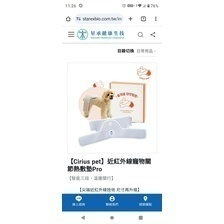

In [16]:
# 測試查詢
test_queries = [
# "CCD 是否與神經發炎相關？有無特定細胞因子（cytokines）或發炎路徑（例如NLRP3 inflammasome）參與？",
# "CCD 是否與腸道微生物群變化有關？是否有特定細菌群落會影響大腦健康？",
# " 失智犬的松果體是否退化",
# " 有刻板形為的犬隻是否會增加CCD風險？",
# " 失智犬分泌褪黑激素的能力是否退化？",
# " 皮質類固醇cortisol或應激荷爾蒙stress hormones是否可作為 CCD 的潛在診斷指標？",
# " 如何區分正常老化與CCD的早期徵兆？ ",
# " B 群維生素是否能降低 CCD 進展風險？",
# " 食用GABA是否對於預防CCD有效？",
# " 警犬、救難犬等工作犬在罹患CCD的機率比較家庭陪伴犬",
# " 目前是否有影像學檢測可以準確區分 CCD 與其他神經退行性疾病？",
# " 如果CCD進展到最後階段，哪些症狀最需要關注？如何平衡狗狗的生活質量與疼痛管理，並且決定狗狗未來的方向",

# "根據資料中對犬認知功能障礙（CCD）神經發炎機制的探討，NLRP3炎症小體在分子層面上如何參與CCD進程？該過程涉及哪些關鍵細胞因子與調控機制？",
# "資料提到腸道微生物群與CCD之間可能存在聯繫，請問文中如何闡述腸道菌群失衡影響神經傳導與免疫反應的分子機制？哪些特定細菌群落的變化被認為與CCD進展相關？",
# "在探討CCD的診斷策略中，該資料對於利用影像學技術（如MRI與CT）區分CCD與其他神經退行性疾病的應用提出了哪些見解？這些技術的優勢與局限性分別是什麼？",
# "資料中對失智犬松果體退化與褪黑激素分泌減少之間的關聯有詳細論述，請問該研究如何描述這一生理變化的分子機制以及其對犬隻睡眠-覺醒週期的影響？",
# "針對CCD的治療策略，資料中提出了哪些基於分子機制的治療方法？請分析這些方法在臨床應用上的現狀、潛在優勢及未來研究中亟待解決的挑戰。",

# "哪種犬容易失智？",
# "大中小型狗的失智照顧方式有什麼不同？"
# "我的狗狗有失智症，晚上總是繞圈圈而且叫個不停，有什麼方法能幫助牠安靜下來睡覺嗎？有人推薦過褪黑激素，這真的有效嗎？",
"我的老狗有認知障礙，經常卡在角落或家具間不知道如何脫困，有什麼環境安排和居家照護措施可以幫助牠更舒適地生活？其他飼主都是怎麼處理這種情況的？"
                    ]

for query in test_queries:
    qa_system.display_response(query)
